In [15]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# navigating your repository
path = Path(os.getcwd())
PROJECT_ROOT = path.parent.absolute()
DATA_PATH = os.path.join(PROJECT_ROOT, r"training-data\data_train_track2_refit.csv")
PLOTS_DIR = os.path.join(PROJECT_ROOT, r"main\plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"Using project root: {PROJECT_ROOT}")
print(f"Train data path: {DATA_PATH}")
print(f"Plots will be saved to: {PLOTS_DIR}")

# Load training data (day-first dates)
df = pd.read_csv(DATA_PATH, header=0 ,sep=';')
df['date'] = pd.to_datetime(df['date'], dayfirst=True)


# Keep Date as first column
df = df[['date'] + [c for c in df.columns if c != 'date']]
feature_cols = [c for c in df.columns if c != 'date']

df["value"] = df["value"].str.replace(",", ".").astype(float)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values('date').reset_index(drop=True)

# 1) Linear time index (trend)
df["time_idx"] = (df["date"] - df["date"].min()).dt.days

# 2) Day-of-year cyclic features (seasonality)
df["doy"] = df["date"].dt.dayofyear

df["doy_sin"] = np.sin(2 * np.pi * df["doy"] / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * df["doy"] / 365.25)

print(df.head())
print(f"Rows: {len(df)}")
print(f"Date range: {df['date'].min().date()} → {df['date'].max().date()}")
print(f"Number of surface points: {len(feature_cols)}")

Using project root: c:\Workspace\quantum repo\MilaHackFest
Train data path: c:\Workspace\quantum repo\MilaHackFest\training-data\data_train_track2_refit.csv
Plots will be saved to: c:\Workspace\quantum repo\MilaHackFest\main\plots
        date  tenor   maturity     value  time_idx  doy   doy_sin   doy_cos
0 2050-01-01      1   0.083333  0.028565         0    1  0.017202  0.999852
1 2050-01-01      9  10.000000  0.253176         0    1  0.017202  0.999852
2 2050-01-01      3   0.250000  0.070905         0    1  0.017202  0.999852
3 2050-01-01     15   3.000000  0.183596         0    1  0.017202  0.999852
4 2050-01-01      5   1.500000  0.162868         0    1  0.017202  0.999852
Rows: 110656
Date range: 2050-01-01 → 2051-12-23
Number of surface points: 3


In [17]:
# split df by date order so test = 20% most recent dates
test_size = 0.2  # 20% most recent rows for test

split_idx = int(len(df) * (1 - test_size))

train_df = df.iloc[:split_idx].copy()  # older data
test_df  = df.iloc[split_idx:].copy() 

print(f"Train date range: {train_df['date'].min()} → {train_df['date'].max()}")
print(f"Test date range:  {test_df['date'].min()} → {test_df['date'].max()}")
print(f"Train rows: {len(train_df)}, Test rows: {len(test_df)}")

Train date range: 2050-01-01 00:00:00 → 2051-08-01 00:00:00
Test date range:  2051-08-01 00:00:00 → 2051-12-23 00:00:00
Train rows: 88524, Test rows: 22132


In [18]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler

TARGET_COL = "value"
DATE_COL = "date"

# All feature columns except raw date + target
feature_cols = [
    c for c in df.columns 
    if c not in [TARGET_COL, DATE_COL, "doy"]  # we keep sin/cos, drop raw doy
]

print("Features:", feature_cols)

feature_cols = ["tenor", "maturity", "time_idx", "doy_sin", "doy_cos"]
TARGET_COL = "value"   # or whatever your target is called

# 1. Numpy arrays (float32 initial cast)
X_train = train_df[feature_cols].to_numpy(dtype=np.float32)
y_train = train_df[TARGET_COL].to_numpy(dtype=np.float32)
X_test  = test_df[feature_cols].to_numpy(dtype=np.float32)
y_test  = test_df[TARGET_COL].to_numpy(dtype=np.float32)

# 2. Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

print("X_train type:", type(X_train), "dtype:", X_train.dtype)

# 3. Tensors (use from_numpy, no dtype confusion)
X_train_t = torch.from_numpy(X_train)                   # torch.float32
X_test_t  = torch.from_numpy(X_test)

y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

Features: ['tenor', 'maturity', 'time_idx', 'doy_sin', 'doy_cos']
X_train type: <class 'numpy.ndarray'> dtype: float32


In [32]:
import perceval as pcvl
import torch.nn as nn
import torch
import torch.nn.functional as F
from merlin import QuantumLayer, LexGrouping
from merlin.builder import CircuitBuilder
import merlin as ML

In [26]:
builder = CircuitBuilder(n_modes=6)
builder.add_entangling_layer(trainable=True, name="U1")
builder.add_angle_encoding(modes=[0, 1, 2, 3, 4], name="input")   # map 5 features -> 5 modes
builder.add_rotations(trainable=True, name="theta")            # extra expressivity
builder.add_superpositions(depth=1)      

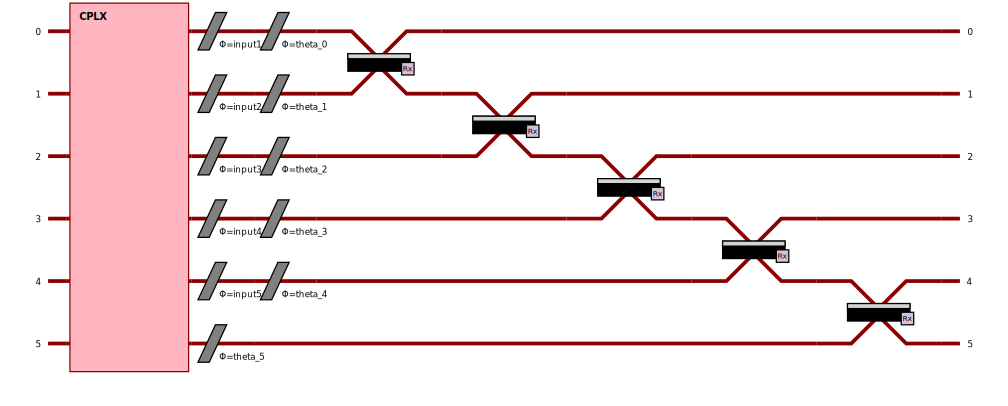

In [27]:
core = QuantumLayer(
    input_size=5,     # number of classical features
    builder=builder,
    n_photons=3,      # equivalent to input_state = [1,1,1,0,0,0]
    dtype=torch.float32,
)
pcvl.pdisplay(core.circuit)

In [33]:
class QuantumInterestRateModel(nn.Module):
    def __init__(
        self,
        input_dim: int,
        classical_hidden: int = 32,
        quantum_input_dim: int = 4,
        quantum_n_params: int = 64,
        head_hidden: int = 32,
        dropout: float = 0.1,
        dtype: torch.dtype = torch.float32,
    ):
        super().__init__()

        # 1) Classical "pre" block: map features -> quantum_input_dim
        self.pre = nn.Sequential(
            nn.Linear(input_dim, classical_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(classical_hidden, quantum_input_dim),
            nn.ReLU(),
        )

        # 2) Quantum layer from MerLin
        #    QuantumLayer.simple builds a ready-to-train photonic circuit
        #    with angle encoding + probabilities as outputs. 
        self.quantum = ML.QuantumLayer.simple(
            input_size=quantum_input_dim,
            n_params=quantum_n_params,
            dtype=dtype,
        )

        # quantum layer has an attribute output_size (length of probability vector) 
        q_out_dim = self.quantum.output_size

        # 3) Classical "head" block: quantum output -> scalar rate
        self.head = nn.Sequential(
            nn.Linear(q_out_dim, head_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch_size, input_dim)
        x = self.pre(x)          # -> (batch_size, quantum_input_dim)
        x = self.quantum(x)      # -> (batch_size, q_out_dim) probabilities / logits
        x = self.head(x)         # -> (batch_size, 1) regression output
        return x

In [36]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

input_dim = X_train_t.shape[1]

model = QuantumInterestRateModel(
    input_dim=input_dim,
    classical_hidden=32,
    quantum_input_dim=4,   # must match pre block output
    quantum_n_params=64,
    head_hidden=32,
    dropout=0.1,
    dtype=torch.float32,
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    train_mse = running_loss / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for X_batch, y_batch in test_loader:
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            test_loss += loss.item() * X_batch.size(0)
        test_mse = test_loss / len(test_loader.dataset)

    print(f"Epoch {epoch+1:3d} | train MSE: {train_mse:.6f} | test MSE: {test_mse:.6f}")

C:\Users\aseri\AppData\Local\Temp\ipykernel_14112\200941663.py:26: RuntimeWarning: Entangling layer introduces 90 trainable parameters, exceeding the requested budget of 64. The simple layer will expose 90 trainable parameters.
  self.quantum = ML.QuantumLayer.simple(


Epoch   1 | train MSE: 0.003006 | test MSE: 0.006560
Epoch   2 | train MSE: 0.000820 | test MSE: 0.005075
Epoch   3 | train MSE: 0.000648 | test MSE: 0.004064
Epoch   4 | train MSE: 0.000565 | test MSE: 0.003597
Epoch   5 | train MSE: 0.000540 | test MSE: 0.002583


In [39]:
def predict_single(model, scaler, df_train, new_row):
    # new_row: dict with raw values, including "date"
    new_df = pd.DataFrame([new_row])
    new_df["date"] = pd.to_datetime(new_df["date"])

    # recreate engineered features (time_idx must use the same reference!)
    new_df["time_idx"] = (new_df["date"] - df_train["date"].min()).dt.days
    new_df["doy"] = new_df["date"].dt.dayofyear
    new_df["doy_sin"] = np.sin(2*np.pi*new_df["doy"]/365.25)
    new_df["doy_cos"] = np.cos(2*np.pi*new_df["doy"]/365.25)

    feature_cols = ["tenor", "maturity", "time_idx", "doy_sin", "doy_cos"]

    # scale features
    X_raw = new_df[feature_cols].to_numpy(dtype=np.float32)
    X_scaled = scaler.transform(X_raw).astype(np.float32)
    X_t = torch.tensor(X_scaled, dtype=torch.float32)

    # model prediction
    model.eval()
    with torch.no_grad():
        pred = model(X_t).item()

    return pred

prediction = predict_single(
    model,
    scaler,
    df,    # full training df, needed for time_idx reference
    {
        "date": "24/12/2051",
        "tenor": 1,
        "maturity": 0.0833333333333333
    }
)

print("Predicted rate:", prediction)

Predicted rate: 0.1542634516954422


C:\Users\aseri\AppData\Local\Temp\ipykernel_14112\293527292.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  new_df["date"] = pd.to_datetime(new_df["date"])
